In [1]:
# Import libraries
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os
import pprint
import string
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score,recall_score, silhouette_score
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from collections import Counter
from nltk.corpus import stopwords
from scipy.cluster.vq import whiten
# from sklearn import datasets
# from sklearn.linear_model import LogisticRegression

In [2]:
df_RedWine = pd.read_csv("Wine Quality - Red.csv", header=0, sep=';')
df_WhiteWine = pd.read_csv("Wine Quality - White.csv", header=0, sep=';')

df_RedWine.head()
#df_WhiteWine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
df_WhiteWine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


## I am going to add labels to the wine types so that we can see if the clustering algorithm has separated them appropriately (or as expected) later:

In [4]:
# Adding Labels:
df_RedWine['wine_type'] = 'Red'
df_WhiteWine['wine_type'] = 'White'

# Combining the data into one dataframe:
df_AllWine = pd.concat([df_RedWine,df_WhiteWine])
#df_AllWine.head()
#df_AllWine.tail()

In [5]:
## Perform kmeans cluster without the 'wine_type' column :
ratings = list(df_AllWine.columns.values)[0:-1]

ratings_pipeline = Pipeline([("imputer", SimpleImputer(strategy="mean")),("scaler", StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ("rating", ratings_pipeline, ratings)
    ], remainder="drop"
)

kmeans_pipeline = Pipeline(
    steps=[("preprocess", preprocessor), ("kmeans", KMeans(n_clusters=2,random_state=0))]
)

## Our "educated guess" for n_clusters is 2, and we will verify with Silhoutte and Elbow methods in following blocks.
kmeans_pipeline.fit(df_AllWine)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('rating',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['fixed acidity',
                                                   'volatile acidity',
                                                   'citric acid',
                                                   'residual sugar',
                                                   'chlorides',
                                                   'free sulfur dioxide',
                                                   'total sulfur dioxide',
                                                   'density', 'pH', 'sulphates',
             

### Now applying the Elbow Method:

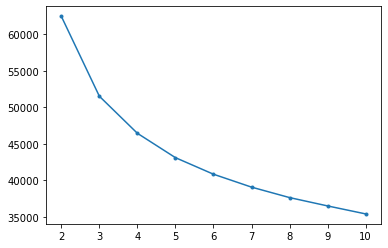

In [7]:
## Elbow method to check our guess of optimal K of 2:

inertia = []
silhouette_coefficients = []
for i in range(2,11):
    kmeans_pipeline.set_params(kmeans__n_clusters=i).fit(df_AllWine)
    inertia.append(kmeans_pipeline['kmeans'].inertia_)
    scaled_features = kmeans_pipeline.named_steps['preprocess'].fit_transform(df_AllWine)
    score = silhouette_score(scaled_features, kmeans_pipeline['kmeans'].labels_)
    silhouette_coefficients.append(score)
    
plt.plot(range(2,11),inertia,marker='.')

### So it looks like the Elbow Method can be misleading. Since the range actually begins at two, the next best n-clusters looks like 3. This and the fact that there is not a very distinct point where the plot changes direction are reasons why a second method should be used to verify.

### The Silhouette Scores Method: We will just look for the n_clusters corresponding to maximum value/score

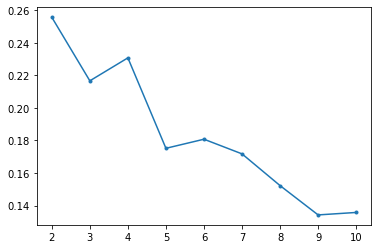

In [8]:
# Just referencing the same data from above:
plt.plot(range(2,11),silhouette_coefficients,marker='.')

### This was a much better chart for this case, as we can clearly see k=2 is the best choice!

In [15]:
#from sklearn import datasets
#from sklearn.linear_model import LogisticRegression

kmeans_pipeline.set_params(kmeans__n_clusters=2).fit(df_AllWine)
df_AllWine['opt_k'] = kmeans_pipeline.predict(df_AllWine)

col = 'wine_type'

df_AllWine.groupby('opt_k')[col].value_counts(normalize=True)

opt_k  wine_type
0      Red          0.943645
       White        0.056355
1      White        0.994823
       Red          0.005177
Name: wine_type, dtype: float64

## It looks like the k-means algorithm did a decent job of classifying the two groups (clusters) of wines, with 94.3% red wine in the first cluster, and 99.5% white wine in the second cluster! 